In [ ]:
!apt-get -qq install -y libarchive-dev && pip install -q -U libarchive
import libarchive

!p7zip -d /content/drive/MyDrive/dataset/iceberg/test_json.7z
!p7zip -d /content/drive/MyDrive/dataset/iceberg/train_json.7z

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.7_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 154 kB 6.2 MB/s 

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/dataset/iceberg/                                                 1 file, 257127394 bytes (246 MiB)

Extracting archive: /content/drive/MyDrive/dataset/iceberg/test_json.7z
--
Path = /content/drive/MyDriv

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

#plt.rcParams['figure.figsize'] = 12, 8
%matplotlib inline

#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

py.init_notebook_mode(connected=True) # plotly 를 jupyter notebook 에 사용하려면 이 커맨드를 입력해야 합니다.

In [ ]:
train = pd.read_json('/content/data/processed/train.json')
test = pd.read_json('/content/data/processed/test.json')

In [ ]:
train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [ ]:
for col in train.columns:
  msg = 'column: {:>15}\t Percent fo NaN value: {:.2f}%'.format(col,100*(train[col].isnull().sum() / train[col].shape[0]))
  print(msg)

column:              id	 Percent fo NaN value: 0.00%
column:          band_1	 Percent fo NaN value: 0.00%
column:          band_2	 Percent fo NaN value: 0.00%
column:       inc_angle	 Percent fo NaN value: 0.00%
column:      is_iceberg	 Percent fo NaN value: 0.00%


* nan값이 업나바...??

In [ ]:
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
print("done!")
train.head()

done!


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


* 우리가 맞추려는 target 은 is_iceberg 이며 1 == iceberg, 0 == ship
* id : 이미지의 ID
* band_1, band_2 : 위성에서 쏜 radar가 특정 object를 만나 튕겨서 다시 돌아오게 되는데 이를 이미지로 저장한 것 (이미지), 1과 2는 서로 각도가 다르다.
* inc_angle : 이미지가 촬영된 입사각, 훈련데이터에는 "na"로 표시도니 누락 데이터가 있다.
* is_iceberg : 목표 변수, 빙산 = 1, 선박 = 0 이며 train.json에만 존재한다.

In [ ]:
for col in train.columns:
  msg = 'column: {:>15}\t Percent fo NaN value: {:.2f}%'.format(col,100*(train[col].isnull().sum() / train[col].shape[0]))
  print(msg)

column:              id	 Percent fo NaN value: 0.00%
column:          band_1	 Percent fo NaN value: 0.00%
column:          band_2	 Percent fo NaN value: 0.00%
column:       inc_angle	 Percent fo NaN value: 0.00%
column:      is_iceberg	 Percent fo NaN value: 0.00%


In [ ]:
train['inc_angle'].value_counts()

na         133
34.4721     23
42.5591     16
36.1061     15
33.6352     15
          ... 
31.5507      1
30.4373      1
24.7546      1
40.3085      1
35.7139      1
Name: inc_angle, Length: 879, dtype: int64

In [ ]:
train.inc_angle = train.inc_angle.replace('na',0)
train['inc_angle'].value_counts()

0.0000     133
34.4721     23
42.5591     16
33.6352     15
36.1061     15
          ... 
45.3846      1
42.5485      1
32.1884      1
42.1683      1
38.1445      1
Name: inc_angle, Length: 879, dtype: int64

* "na"로 누락된 데이터를 0으로 바꾸어 준다.

In [ ]:
#train, test set의 크기 확인
print('Shape of train set:', train.shape)
print('Shape of test set:', test.shape)

Shape of train set: (1604, 5)
Shape of test set: (8424, 4)


In [ ]:
#train set의 band_1, band_2 feature의 크기 확인
print("Shape of band 1:",  np.shape(train.band_1.iloc[0]))
print("Shape of band 2:",  np.shape(train.band_2.iloc[0]))

Shape of band 1: (5625,)
Shape of band 2: (5625,)


In [ ]:
#train set의 band_1, band_2 feature의 data type 확인
print("Type of band 1:",  type(train.band_1.iloc[0]))
print("Type of band 2:",  type(train.band_2.iloc[0]))

Type of band 1: <class 'list'>
Type of band 2: <class 'list'>


In [ ]:
#Generate the training data
#Create 3 bands having HH, HV and avg of both

# reshape(75 ,75)
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

#np.concatenate해서 새로운 채널을 하나더 만들어주는 것
# band1과 band2데이터를 합치고 이를 3D image로 변환하기
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)


X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [ ]:
print("Shape of band 1 image:",X_band_1.shape)
print("Shape of band 2 image:",X_band_2.shape)

#(1471,5625)가 (1471,75,75)로 변화하였다 -> 2D image로 변환 (추후 Conv2D 연산을 위해 N x Height x Width 꼴로 변환)
#원래는 N x Height x Width x Channel 꼴로 변환해야 하는데, Channel은 밑에서 추가함.

Shape of band 1 image: (1604, 75, 75)
Shape of band 2 image: (1604, 75, 75)


In [ ]:
print("Shape of test set band 1 image:",X_band_test_1.shape)
print("Shape of test set band 2 image:",X_band_test_2.shape)

Shape of test set band 1 image: (8424, 75, 75)
Shape of test set band 2 image: (8424, 75, 75)


In [ ]:
print("Shape of image_train:",X_train.shape)

Shape of image_train: (1604, 75, 75, 3)


* band_1 과 band_2가 HH,HV 2채널로 이루어져 있기 때문에 3채널로 만들어준다.

In [ ]:
def plot_contour_2d(band1, band2, label):
    fig, ax = plt.subplots(1, 2, figsize=(16, 10))
    ax[0].imshow(X_band_1[num, :, :])
    ax[0].set_title('Image from band_1', fontsize=15)
    ax[1].imshow(X_band_2[num, :, :])
    ax[1].set_title('Image from band_2', fontsize=15)
    plt.show()

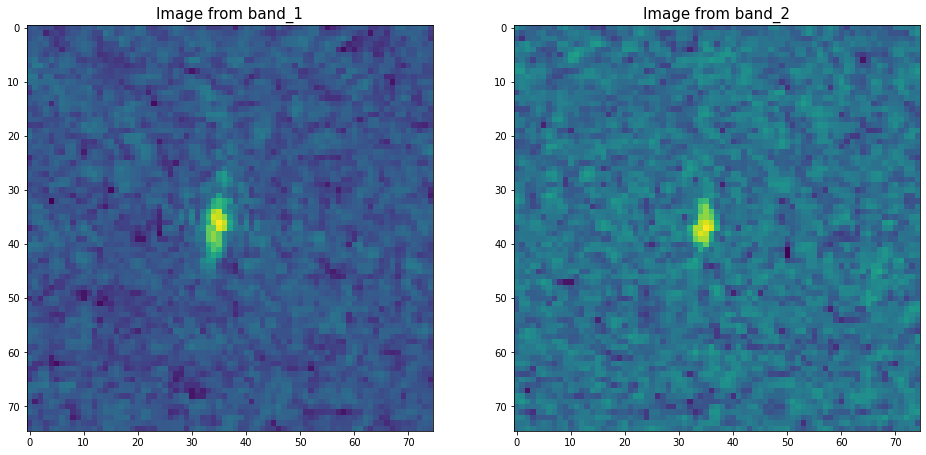

In [ ]:
num = 0
label = 'iceberg' if (train['is_iceberg'].values[num] == 1) else'ship'
plot_contour_2d(X_band_1[num,:,:], X_band_2[num,:,:], label)

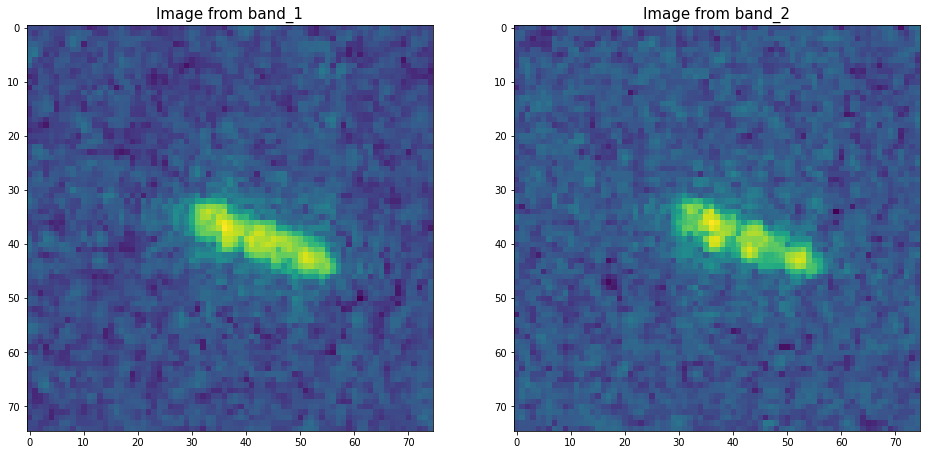

In [ ]:
num = 100
label = 'iceberg' if (train['is_iceberg'].values[num]==1) else 'ship'
plot_contour_2d(X_band_1[num,:,:],X_band_2[num,:,:],label)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch import optim
import torch.utils.data as utils
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image

In [ ]:
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3,64,3),
        nn.ReLU(),
        nn.MaxPool2d(3,stride=(2,2)),
        nn.Dropout2d(0.2),

        nn.Conv2d(64,128,3),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=(2,2)),
        nn.Dropout2d(0.2),

        nn.Conv2d(128,128,3),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=(2,2)),
        nn.Dropout2d(0.2),

        nn.Conv2d(128,64,3),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=(2,2)),
        nn.Dropout2d(0.2),
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(256,512),
        nn.ReLU(),
        nn.Dropout2d(0.2),

        nn.Linear(512,256),
        nn.ReLU(),
        nn.Dropout2d(0.2),

        nn.Linear(256,128),
        nn.ReLU(),
        nn.Dropout2d(0.2),

        nn.Linear(128,2)
    )
  def forward(self,x):
    out = self.layer(x)
    out = out.view(out.size(0),-1)
    out = self.fc_layer(out)

    return out

* Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

* in_channels: 입력 채널 수. 흑백 이미지일 경우 1, RGB 값을 가진 이미지일 경우 3
* out_channels: 출력 채널 수
* kernel_size: 커널 사이즈
* stride: stride 사이즈. 기본 값은 1
* padding: padding 사이즈. 기본 값은 0
* padding_mode: padding mode를 설정. 기본 값은 'zeros' 
* dilation: 커널 사이 간격 사이즈를 조절
* groups: 입력 층의 그룹 수을 설정하여 입력의 채널 수를 그룹 수에 맞게 분류 합니다. 그 다음, 출력의 채널 수를 그룹 수에 맞게 분리하여, 입력 그룹과 출력 그룹의 짝을 지은 다음 해당 그룹 안에서만 연산이 이루어지게 합니다.
* bias: bias 값을 설정 할 지, 말지를 결정. 기본 값은 True

In [ ]:
class MyDataset(Dataset):
  def __init__(self,X,y,transform=None):
    self.X = X
    self.y = y
    self.transform = transform
  def __len__(self):
    return len(self.X)

  def __getitem__(self,i):
    x = self.X[i]
    if self.transform is not None:
      x = self.transform(x)
    y = self.y[i]

    return x,y

In [ ]:
target_train =train['is_iceberg']
X_train, X_valid, y_train, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.8)

In [ ]:
train_dataset = MyDataset(X_train,torch.LongTensor(y_train),transform=transforms.Compose([transforms.ToTensor()]))
train_batch = DataLoader(train_dataset, batch_size=24,shuffle=True, drop_last=True)

In [ ]:
valid_dataset = MyDataset(X_valid,torch.LongTensor(y_valid.values),transform=transforms.Compose([transforms.ToTensor()]))
valid_batch = DataLoader(valid_dataset,batch_size=24,shuffle=False,drop_last=True)

In [ ]:
model = MyModel().cuda()

* correct: 맞은 개수를 저장할 변수
* total: 전체 개수를 저장할 변수
* torch.no_grad(): 기울기를 계산하지 않는 상태에서 테스트를 진행한다는 의미이다. 이런 상황에서 테스트를 진행하게 되면 계속해서 Model을 Trainning하면서 결과를 확인하게 되므로 측정하고자 하는 Model의 상태에서 Test하는 환경이 아니다.
* torch.max(output,1): Test진행 후 Model에서 최대값과 Index를 구하는 작업
* label.size(0): 현재 Model은 Batch로 처리하고 있기 때문에 Batch Size만큼을 반환하기 위해서 선언

Test Data Set으로 정확도 확인

In [ ]:
# Test Data Set으로 정확도 확인

def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0

    for i, (imgs, labels) in enumerate(dloader):
      # 두 데이터 모두 장치에 올립니다.
        img = Variable(imgs,requires_grad=True).cuda()
        label = Variable(labels).cuda()

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = imodel.forward(img)

        # torch.max를 이용해 최대 값 및 최대값 인덱스를 뽑아냅니다.
        # 여기서는 최대값은 필요없기 때문에 인덱스만 사용합니다.
        _, output_index = torch.max(output,1)

        # 전체 개수는 라벨의 개수로 더해줍니다.
        # 전체 개수를 알고 있음에도 이렇게 하는 이유는 batch_size, drop_last의 영향으로 몇몇 데이터가 잘릴수도 있기 때문입니다.
        total+=label.size(0)

        # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줍니다.
        correct+=(output_index==label).sum().float()

    print('Accuracy of Test Data: {}'.format(100*correct/total))

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func= nn.CrossEntropyLoss()
x=[]
y=[]

# 정의한 반복 횟수만큼 Model을 Trainning 하는 과정이다.

for i in range(10):
  for j,(data, label) in enumerate(train_batch):
    data = Variable(data).cuda()
    label = Variable(label).cuda()
    
    optimizer.zero_grad()
    out = model(data)
    loss = loss_func(out,label)
    loss.backward()
    optimizer.step()
    
  model.eval()
  ComputeAccr(train_batch,model)
  print('epoch: %d loss %.3f' %((i+1),loss))
  model.train()
  x.append(i)
  y.append(loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning:

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)



Accuracy of Test Data: 68.1603775024414
epoch: 1 loss 0.569
Accuracy of Test Data: 71.77672576904297
epoch: 2 loss 0.454
Accuracy of Test Data: 71.22640991210938
epoch: 3 loss 1.089
Accuracy of Test Data: 80.26729583740234
epoch: 4 loss 0.374
Accuracy of Test Data: 77.75157165527344
epoch: 5 loss 0.534
Accuracy of Test Data: 82.46855163574219
epoch: 6 loss 0.437
Accuracy of Test Data: 80.97483825683594
epoch: 7 loss 0.442
Accuracy of Test Data: 83.96226501464844
epoch: 8 loss 0.416
Accuracy of Test Data: 82.46855163574219
epoch: 9 loss 0.284
Accuracy of Test Data: 80.18867492675781
epoch: 10 loss 0.219
